In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [ ]:
from zipfile import ZipFile

with ZipFile("/content/drive/MyDrive/archive.zip","r") as zipper:
  zipper.extractall()
  print("Done")

Done


In [ ]:
data = pd.read_csv("/content/ner_dataset.csv", encoding="latin1").fillna(method="ffill")

In [ ]:
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
class Sentence(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda x:[(w, p, t) for w, p, t in zip(x["Word"].values.tolist(),
                                                          x["POS"].values.tolist(),
                                                          x["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [sen for sen in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[f"Sentence: {self.n_sent}"]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
dataset = Sentence(data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in dataset.sentences]

In [ ]:
len(sentences)

47959

In [ ]:
labels = [[token[2] for token in sentence] for sentence in dataset.sentences]

In [ ]:
print(sentences[0])
print(labels[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i,t in enumerate(tag_values)}

In [ ]:
tag2idx

{'B-art': 14,
 'B-eve': 16,
 'B-geo': 1,
 'B-gpe': 3,
 'B-nat': 11,
 'B-org': 8,
 'B-per': 4,
 'B-tim': 5,
 'I-art': 2,
 'I-eve': 12,
 'I-geo': 15,
 'I-gpe': 7,
 'I-nat': 6,
 'I-org': 9,
 'I-per': 13,
 'I-tim': 10,
 'O': 0,
 'PAD': 17}

Apply BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 5.9MB/s 
     |████████████████████████████████| 890kB 50.1MB/s 
     |████████████████████████████████| 3.2MB 56.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=511122ab0ee06fe772c43c1dafa1d5ec6badab757e743bb106b7c98db2ff1084
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

We will limit our sequence length to 75 tokens and we will use a batch size of 32 as suggested by the Bert paper.

Bert supports sequences upto 512 tokens

In [ ]:
MAX_LEN = 75
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case = False)

Now we tokenize all sentences. Since the Bert tokenizer is based a Wordpiece tokenizer it will split tokens in subwords tokens. For example 'gunships' will be split in the two tokens 'guns' and '##hips'. We have to deal with the issue of splitting our token-level labels to related subtokens. In practice you would solve this by a specialized data structure based on label spans, but for simplicity I do it explicity here.

In [ ]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels n_subwords times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_text_and_labels = [
                             tokenize_and_preserve_labels(sent, labs)
                             for sent, labs in zip(sentences, labels)
]

In [ ]:
tokenized_text = [token_label_pair[0] for token_label_pair in tokenized_text_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_text_and_labels]

In [ ]:
from keras.preprocessing.sequence import pad_sequences

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_text],
                          maxlen = MAX_LEN, dtype = "long", value = 0.0,
                          truncating = "post", padding = "post")

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen = MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

The Bert model supports something called "attention mask".

The attention mask is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.


In [ ]:
attention_mask = [[float(i != 0.0) for i in ii] for ii in input_ids]

Now we split the dataset ito use 10% to validate the model

In [ ]:
from sklearn.model_selection import train_test_split

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, random_state=42, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_mask, input_ids, random_state=42, test_size=0.1)

In [ ]:
# Convert the dataset to torch tensors

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
# make dataloader for training and testing
'''
We shuffle the data at training time with RandomSampler and at the test time we
pass them sequentially with the SequentialSampler
'''
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler = train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_loader = DataLoader(valid_data, sampler = valid_sampler, batch_size=bs)

Setup and Bert Model fintuning

The token-level classifier is a linear layer that takes as input the last hidden state of the sequence. We load the pre trained bert-based-cased model and provide the number of possible labels

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels = len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params' : [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate' : 0.01},
         {'params' : [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
          'weight_decay_rate':0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n,p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr = 3e-5,
    eps = 1e-8
)

We also add a scheduler to linearly reduce the learning rate throughout the epochs.

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

seqeval is a Python framework for sequence labeling evaluation. seqeval can evaluate the performance of chunking tasks such as named-entity recognition, part-of-speech tagging, semantic role labeling and so on.

In [ ]:
!pip install seqeval

     |████████████████████████████████| 51kB 3.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=e0452fabd5cf294c578fa25aaae8da7e911755e21f322707f10a48adb521ed06
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
from seqeval.metrics import f1_score, accuracy_score
from tqdm import tqdm, trange

In [ ]:
train_losses = []
validation_losses = []

for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data in train_loader:
        data = tuple(t.to(device) for t in data)
        inputs, masks, labels = data

        model.zero_grad()
        outputs = model(inputs,token_type_ids = None, attention_mask = masks, labels=labels)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item()

    model.eval()
    for data in valid_loader:
        data = tuple(t.to(device) for t in data)
        inputs, masks, labels = data
        model.zero_grad()
        outputs = model(inputs, attention_mask = masks,token_type_ids = None, labels=labels)
        loss = outputs[0]

        valid_loss += loss.item()
    
    scheduler.step()
     # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)

    print(f"Epoch {epoch}: \t Training Loss:  {train_loss} \t Validation Loss:  {valid_loss}")


Epoch 1: 	 Training Loss:  0.06075968286692213 	 Validation Loss:  0.14439690995961427
Epoch 2: 	 Training Loss:  0.046097566648417486 	 Validation Loss:  0.15206888825943074
Epoch 3: 	 Training Loss:  0.03574701266489603 	 Validation Loss:  0.1763591421023011


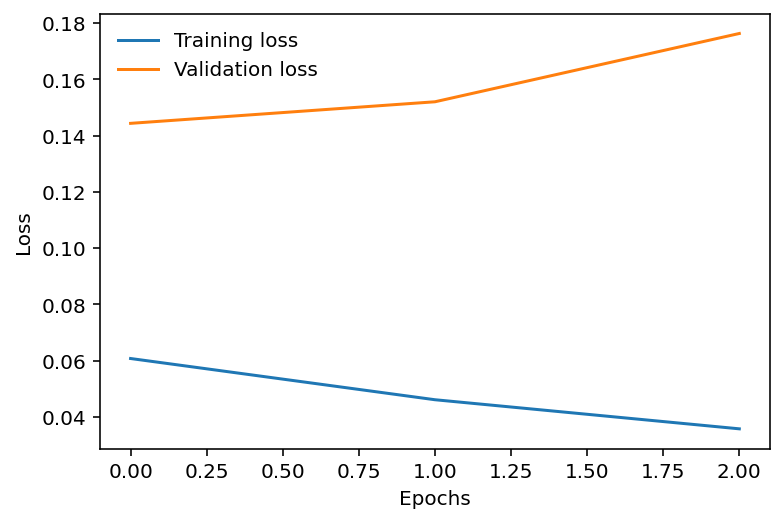

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
test_sentence = '''
Lionel Andrés Messi is a footballer.He was born on 24 June 1987 in Rosario, Argentina.
'''

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).to(device)

In [ ]:
with torch.no_grad():
    outputs = model(input_ids)
label_indices = np.argmax(outputs[0].to('cpu').numpy(), axis = 2)

In [ ]:
# join the split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print(f"{label}     {token}")

O     [CLS]
B-per     Lionel
I-per     Andrés
I-per     Messi
O     is
O     a
O     footballer
O     .
O     He
O     was
O     born
O     on
B-tim     24
I-tim     June
I-tim     1987
O     in
B-geo     Rosario
O     ,
B-geo     Argentina
O     .
O     [SEP]
